# Netflix EDA, Recommendation 
- 넷플릭스 데이터셋으로부터 유의미한 정보를 도출해보자!

In [10]:
# install packages
# comment out the following lines for installing packages

# !pip install plotly_express
# !pip install --upgrade nbformat
# !pip install wordcloud 


In [11]:
# import packages (python 3.10)
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Reference: https://www.kaggle.com/code/niharika41298/netflix-visualizations-recommendation-eda/notebook

In [12]:
# dataset path
DATASET_ROOT_PATH = "../data/netflix-recommendation"

In [13]:
# load dataset
netflix_df = pd.read_csv(f"{DATASET_ROOT_PATH}/netflix_titles.csv")
netflix_df.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...


In [14]:
# Check types and non-null count for each columns 
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [15]:
# 중복데이터 없음
netflix_df.duplicated().sum()

0

In [16]:
netflix_df.show_id.duplicated().sum()

0

In [17]:
netflix_df.title.duplicated().sum()

0

## Data Exploration
### 컬럼별 결측치 확인 (NaN 확인)
- director 2634
- cast 825
- country 831
- date_added 10
- rating 4 (rating 데이터 오류 해결하면서 +3 됨)
- duration 3 (rating 데이터 오류가 해결되면서 결측치 -3 됨)

In [18]:
netflix_df.isna().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

## 데이터 오류 확인
- rating 컬럼에 74 min, 84 min, 66 min 이라는 데이터가 들어간 데이터 오류 발견함
- 해당 데이터 확인 및 수정 가능한지 확인해봅니다.

In [19]:
# Determine unique values for 'rating' column
netflix_df["rating"].value_counts()

rating
TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
74 min         1
84 min         1
66 min         1
Name: count, dtype: int64

In [20]:
rating_error_check = (netflix_df.rating == '74 min') | (netflix_df.rating == '84 min') | (netflix_df.rating == '66 min')
netflix_df.loc[rating_error_check, :]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
5541,s5542,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,"April 4, 2017",2017,74 min,NaN,Movies,"Louis C.K. muses on religion, eternal love, gi..."
5794,s5795,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,"September 16, 2016",2010,84 min,NaN,Movies,Emmy-winning comedy writer Louis C.K. brings h...
5813,s5814,Movie,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,"August 15, 2016",2015,66 min,NaN,Movies,The comic puts his trademark hilarious/thought...


In [21]:
netflix_df.loc[netflix_df.rating.isna(), :]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
5989,s5990,Movie,13TH: A Conversation with Oprah Winfrey & Ava ...,NaN,"Oprah Winfrey, Ava DuVernay",NaN,"January 26, 2017",2017,NaN,37 min,Movies,Oprah Winfrey sits down with director Ava DuVe...
6827,s6828,TV Show,Gargantia on the Verdurous Planet,NaN,"Kaito Ishikawa, Hisako Kanemoto, Ai Kayano, Ka...",Japan,"December 1, 2016",2013,NaN,1 Season,"Anime Series, International TV Shows","After falling through a wormhole, a space-dwel..."
7312,s7313,TV Show,Little Lunch,NaN,"Flynn Curry, Olivia Deeble, Madison Lu, Oisín ...",Australia,"February 1, 2018",2015,NaN,1 Season,"Kids' TV, TV Comedies","Adopting a child's perspective, this show take..."
7537,s7538,Movie,My Honor Was Loyalty,Alessandro Pepe,"Leone Frisa, Paolo Vaccarino, Francesco Miglio...",Italy,"March 1, 2017",2015,NaN,115 min,Dramas,"Amid the chaos and horror of World War II, a c..."


### rating 데이터 오류 분석 결과
- duration 정보가 rating 에 들어간 경우이다.
- rating 을 NaN 으로 변경하고 duration 에 넣어준다.
- 혹시나 rating 이 NaN 인 애들도 비슷한 경우일까 찾아봤는데 그건 아니었다.

In [22]:
# 데이터 오류 수정
netflix_df = netflix_df.apply(
  lambda row: row if row.rating not in ['74 min', '84 min', '66 min'] else pd.Series({**row, 'rating': np.NaN, 'duration': row.rating}),
  axis=1
)

netflix_df.loc[netflix_df.rating.isin(['74 min', '84 min', '66 min']), :]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description


In [23]:
# 수정 결과 확인
netflix_df.loc[netflix_df.title == 'Little Lunch', :]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
7312,s7313,TV Show,Little Lunch,NaN,"Flynn Curry, Olivia Deeble, Madison Lu, Oisín ...",Australia,"February 1, 2018",2015,NaN,1 Season,"Kids' TV, TV Comedies","Adopting a child's perspective, this show take..."


## Country 데이터 오류 유무 확인
- 데이터 오류 없음을 확인함
- 전 Player1 의 분석 결과에서 있었던 USA 는 imdb 와 합치는 중 들어간 데이터로 추측
### 특이사항
- West Germany, East Germany, Germany 이렇게 세가지로 구분됨. 추후 분석 시, 문제가 된다면 Germany 로 통합시켜야 할 수 있다.

In [24]:
# value_counts() 등 모든 데이터들에 대한 정보 확인을 위해 display.max_rows 를 None 으로 설정합니다.
# default value is 60
# [reference] https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
pd.set_option("display.max_rows", None)
print(netflix_df["country"].value_counts())

# set back the value of display.max_rows to default value 60
pd.set_option("display.max_rows", 60)

country
United States                                                                                                                  2818
India                                                                                                                           972
United Kingdom                                                                                                                  419
Japan                                                                                                                           245
South Korea                                                                                                                     199
Canada                                                                                                                          181
Spain                                                                                                                           145
France                                                              

In [25]:
# 유니크 값을 제대로 확인하기 위해 반복문 사용
unique_country = set()
for cntry in netflix_df.country:
  if not pd.isna(cntry): # country 결측치 831
    lst_country = [c.strip() for c in cntry.split(',')]
    unique_country = unique_country.union(set(lst_country))
unique_country

{'',
 'Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Bermuda',
 'Botswana',
 'Brazil',
 'Bulgaria',
 'Burkina Faso',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cayman Islands',
 'Chile',
 'China',
 'Colombia',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Dominican Republic',
 'East Germany',
 'Ecuador',
 'Egypt',
 'Ethiopia',
 'Finland',
 'France',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Guatemala',
 'Hong Kong',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Iran',
 'Iraq',
 'Ireland',
 'Israel',
 'Italy',
 'Jamaica',
 'Japan',
 'Jordan',
 'Kazakhstan',
 'Kenya',
 'Kuwait',
 'Latvia',
 'Lebanon',
 'Liechtenstein',
 'Lithuania',
 'Luxembourg',
 'Malawi',
 'Malaysia',
 'Malta',
 'Mauritius',
 'Mexico',
 'Mongolia',
 'Montenegro',
 'Morocco',
 'Mozambique',
 'Namibia',
 'Nepal',
 'Netherlands',
 'New Zealand',
 'Nicaragua',
 'Nigeria',
 'Nor

### Country 데이터 전처리
- 현재 스트링으로 쉼표(,) 로 구분되어 들어가있다.
- 좀 더 편한 분석을 위한 전처리 한다.

In [26]:
# 몇개의 나라에서 공동 제작했는지, 나라 수에 대한 컬럼을 생성한다.
# NaN 의 경우, 0으로 표기한다.

def country_eda(row: pd.Series):
  updated_row = {}
  if pd.isna(row.country):
    updated_row = {
      "num_country": 0
    }
  else:
    countries = row.country.split(',')
    lst_country = [c.strip() for c in countries]
    updated_row = {
      "num_country": len(lst_country),
      # "country": lst_country
    }
  return pd.Series({**row, **updated_row})

netflix_df = netflix_df.apply(
  lambda row: country_eda(row),
  axis=1
)
netflix_df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,num_country
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",1
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",1
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,0
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",0
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a...",1
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g...",0
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...,1
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",1


In [27]:
netflix_df.num_country.unique()

array([ 1,  0,  6,  2,  3,  4,  5,  8,  7, 12, 10])

In [28]:
type(netflix_df.country[0])

str

## Type 별 date_added 와 release_year 데이터분석
- TV show 보다 Movie 의 제작량이 많은 것을 확인할 수 있다.
- 2000 년도부터 꾸준히 상승세를 보이다 2020 년도부터 하락세를 보인다.
  - 아마도 코로나의 영향이지 않을까 추측한다.
  - 확신하기엔 데이터가 2021 년도까지 밖에 없다.
  #
- date_added 의 year 와 month 를 구분하여 분석해보았다.
  - year 는 year_released 와 큰 차이 없었다.
  - month 는 특이사항을 발견하지 못했다.
  #
- 추가 분석 가능한 부분
  - release year 와 year added 의 차를 구하는 것
  - netflix 가 2007년부터 유명해졌으므로 그 년도를 기준으로 이후의 년도에서 유의미한 데이터를 구할 수 있지 않을까 추측한다.
  - 하지만 시간적 여유가 없어서 우선 보류한다.

In [29]:
# Determine unique values for 'type' column
netflix_df["type"].value_counts() # value_counts: pd.Series에서 고유한 값들의 각 개수를 알려준다. 

type
Movie      6131
TV Show    2676
Name: count, dtype: int64

In [30]:
# Check earliest and latest release_year
print(netflix_df["release_year"].min(), "~", netflix_df["release_year"].max())

1925 ~ 2021


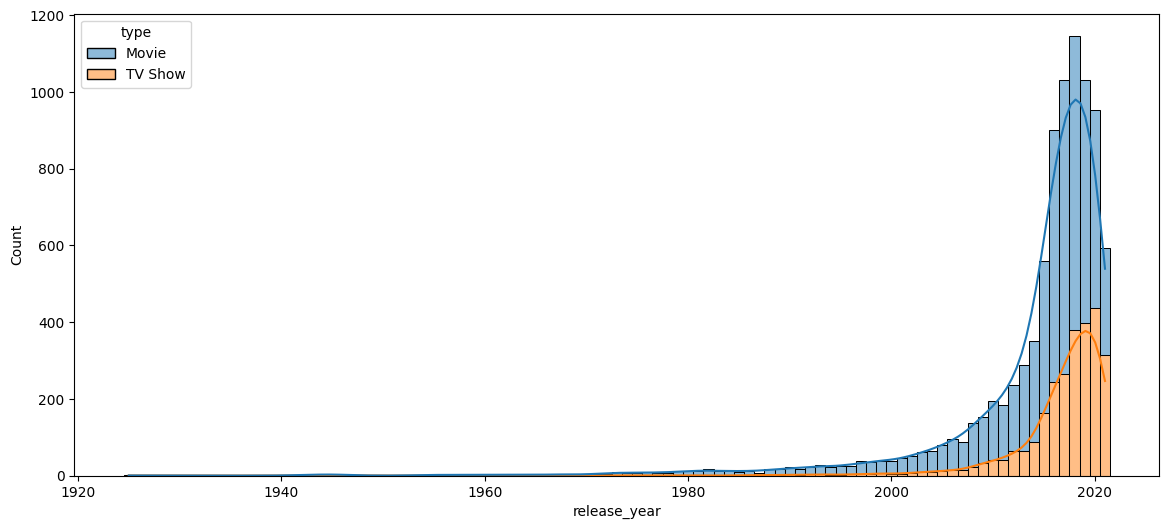

In [31]:
plt.figure(figsize=(14, 6))
sns.histplot(netflix_df, x='release_year', hue='type', multiple="stack", kde=True, discrete=True)
plt.show()

In [32]:
type(netflix_df.date_added[0])

str

In [33]:
# 시각화 분석을 위해 year_added 를 추가합니다.
netflix_df['year_added'] = netflix_df.date_added.map(lambda date: date if pd.isna(date) else date.split(",")[-1].strip())
netflix_df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,num_country,year_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",1,2021
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",1,2021
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,0,2021
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",0,2021
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,1,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a...",1,2019
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g...",0,2019
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...,1,2019
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",1,2020


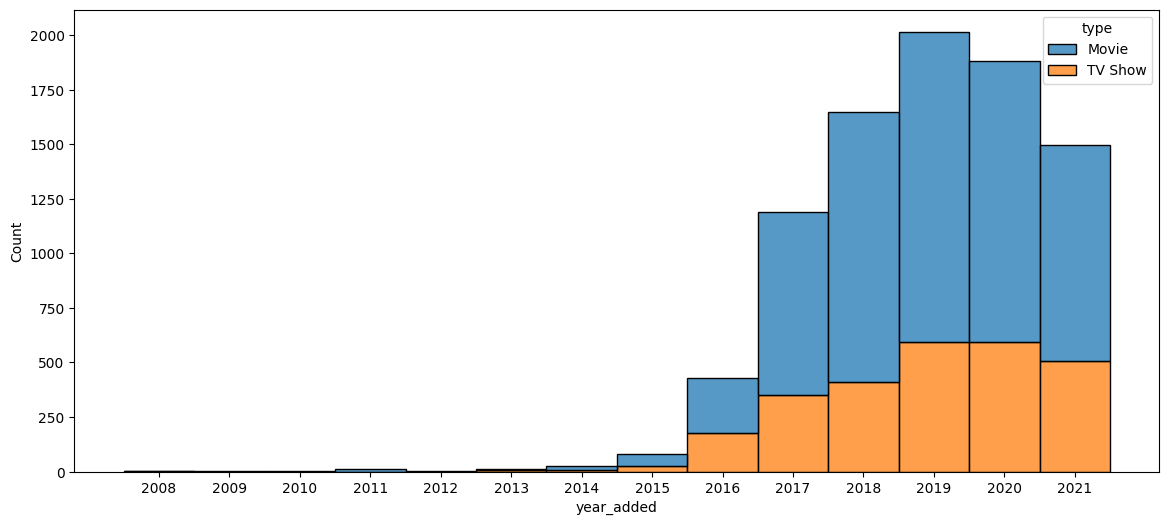

In [34]:
plt.figure(figsize=(14, 6))
sns.histplot(netflix_df.sort_values('year_added'), x='year_added', hue='type', multiple="stack", discrete=True)
plt.show()

In [35]:
# 시각화 분석을 위해 month_added 를 추가합니다.
netflix_df['month_added'] = netflix_df.date_added.map(lambda date: date if pd.isna(date) else date.split(" ")[0].strip())
netflix_df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,num_country,year_added,month_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",1,2021,September
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",1,2021,September
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,0,2021,September
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",0,2021,September
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,1,2021,September
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a...",1,2019,November
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g...",0,2019,July
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...,1,2019,November
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",1,2020,January


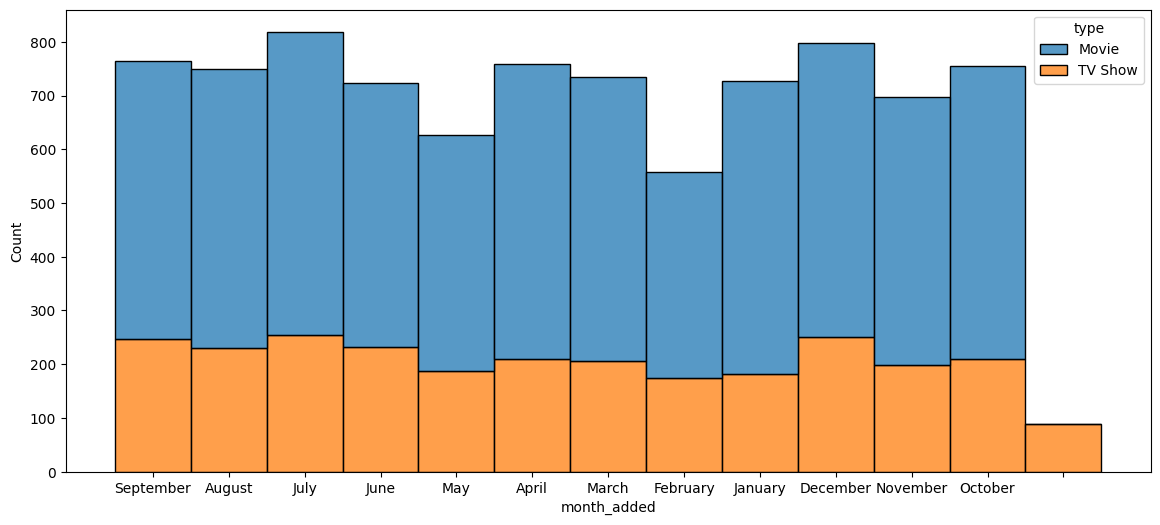

In [36]:
plt.figure(figsize=(14, 6))
sns.histplot(netflix_df, x='month_added', hue='type', multiple="stack", discrete=True)
plt.show()

## 국가별 시간대별 데이터
- 국가별로 제작 참여한 국가들을 분리하고 년도별 데이터를 분석한다.
- 국가가 여러개인 데이터의 경우가 있기 때문에 데이터셋을 새로 구축한다.
- original netflix dataset 에 영향이 가지 않도록 복사본에서 실험한다.

### 분석결과
- netflix 가 미국 회사라 그런지 확실히 United States 가 제작 참여한 영상이 압도적으로 양이 많았다.
  - United States 다음으론 India, United Kingdom 등 영어권 나라가 있었다.
- 시간대별 나라별 영상의 제작 추이는 특이사항이 없다.


In [37]:
df_copy = netflix_df.copy()
df_copy.loc[netflix_df.num_country > 1]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,num_country,year_added,month_added
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s...",6,2021,September
12,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic","September 23, 2021",2021,TV-MA,127 min,"Dramas, International Movies",After most of her family is murdered in a terr...,2,2021,September
29,s30,Movie,Paranoia,Robert Luketic,"Liam Hemsworth, Gary Oldman, Amber Heard, Harr...","United States, India, France","September 19, 2021",2013,PG-13,106 min,Thrillers,"Blackmailed by his company's CEO, a low-level ...",3,2021,September
38,s39,Movie,Birth of the Dragon,George Nolfi,"Billy Magnussen, Ron Yuan, Qu Jingjing, Terry ...","China, Canada, United States","September 16, 2021",2017,PG-13,96 min,"Action & Adventure, Dramas",A young Bruce Lee angers kung fu traditionalis...,3,2021,September
46,s47,Movie,Safe House,Daniel Espinosa,"Denzel Washington, Ryan Reynolds, Vera Farmiga...","South Africa, United States, Japan","September 16, 2021",2012,R,115 min,Action & Adventure,Young CIA operative Matt Weston must get a dan...,3,2021,September
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8788,s8789,Movie,You Carry Me,Ivona Juka,"Lana Baric, Vojislav Brajovic, Natasa Janjic, ...","Croatia, Slovenia, Serbia, Montenegro","July 1, 2016",2015,TV-MA,157 min,"Dramas, International Movies","A soap opera producer, director and makeup art...",4,2016,July
8794,s8795,Movie,اشتباك,Mohamed Diab,"Nelly Karim, Hany Adel, Tarek Abdel Aziz, Ahme...","Egypt, France","October 11, 2018",2016,TV-14,98 min,"Dramas, Independent Movies, International Movies",Amid the tumult following Egyptian President M...,2,2018,October
8795,s8796,TV Show,Yu-Gi-Oh! Arc-V,NaN,"Mike Liscio, Emily Bauer, Billy Bob Thompson, ...","Japan, Canada","May 1, 2018",2015,TV-Y7,2 Seasons,"Anime Series, Kids' TV",Now that he's discovered the Pendulum Summonin...,2,2018,May
8797,s8798,TV Show,Zak Storm,NaN,"Michael Johnston, Jessica Gee-George, Christin...","United States, France, South Korea, Indonesia","September 13, 2018",2016,TV-Y7,3 Seasons,Kids' TV,Teen surfer Zak Storm is mysteriously transpor...,4,2018,September


In [38]:
# 시간 복잡도 최악이다.
# 그치만 그냥 일단 확인해보는 용도라고 생각하고 최악의 기법으로 간다.
# 코드 업그레이드 필요 
df_loop = df_copy.loc[netflix_df.num_country > 1].copy()
df_copy = df_copy.loc[netflix_df.num_country <= 1].copy()
for idx, row in df_loop.iterrows():
  countries = [cntry.strip() for cntry in row.country.split(',')]
  for cntry in countries:
    if cntry.find(",") != -1:
      print(cntry)
    df_copy = pd.concat([df_copy, pd.DataFrame({
      **row,
      "country": cntry,
    }, index=[0])], ignore_index=True)
  df_copy.drop(idx, inplace=True)
df_copy.reset_index(drop=True, inplace=True)
df_copy


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,num_country,year_added,month_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",1,2021,September
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",1,2021,September
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,0,2021,September
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",0,2021,September
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,1,2021,September
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9525,s8798,TV Show,Zak Storm,NaN,"Michael Johnston, Jessica Gee-George, Christin...",France,"September 13, 2018",2016,TV-Y7,3 Seasons,Kids' TV,Teen surfer Zak Storm is mysteriously transpor...,4,2018,September
9526,s8798,TV Show,Zak Storm,NaN,"Michael Johnston, Jessica Gee-George, Christin...",South Korea,"September 13, 2018",2016,TV-Y7,3 Seasons,Kids' TV,Teen surfer Zak Storm is mysteriously transpor...,4,2018,September
9527,s8798,TV Show,Zak Storm,NaN,"Michael Johnston, Jessica Gee-George, Christin...",Indonesia,"September 13, 2018",2016,TV-Y7,3 Seasons,Kids' TV,Teen surfer Zak Storm is mysteriously transpor...,4,2018,September
9528,s8802,Movie,Zinzana,Majid Al Ansari,"Ali Suliman, Saleh Bakri, Yasa, Ali Al-Jabri, ...",United Arab Emirates,"March 9, 2016",2015,TV-MA,96 min,"Dramas, International Movies, Thrillers",Recovering alcoholic Talal wakes up inside a s...,2,2016,March


In [39]:
df_copy.country.unique()

array(['United States', 'South Africa', nan, 'India', 'Mexico', 'Turkey',
       'Australia', 'United Kingdom', 'Finland', 'Nigeria', 'Japan',
       'France', 'Belgium', 'South Korea', 'Russia', 'Canada', 'Ireland',
       'Italy', 'Argentina', 'Spain', 'Jordan', 'Colombia', 'Taiwan',
       'Poland', 'Germany', 'New Zealand', 'Saudi Arabia', 'Indonesia',
       'Thailand', 'Egypt', 'Malaysia', 'Israel', 'Vietnam', 'Sweden',
       'China', 'Brazil', 'Romania', 'Philippines', 'Iceland', 'Denmark',
       'United Arab Emirates', 'Mauritius', 'Austria', 'Lebanon',
       'Netherlands', 'Kenya', 'Uruguay', 'Luxembourg', 'Bangladesh',
       'Norway', 'Senegal', 'Singapore', 'Kuwait', 'Namibia',
       'Mozambique', 'Belarus', 'Ghana', 'Chile', 'Zimbabwe', 'Cyprus',
       'Switzerland', 'Pakistan', 'Hong Kong', 'Croatia', 'Peru',
       'Cambodia', 'Bulgaria', 'Georgia', 'Hungary', 'West Germany',
       'Venezuela', 'Ukraine', 'Burkina Faso', 'Czech Republic', '',
       'Nepal', 'Greec

In [40]:
# country 컬럼에 대한 데이터 분석을 진행합니다.
plot_data_country = df_copy.groupby("country").count().reset_index()
plot_data_country

,country,show_id,type,title,director,cast,date_added,release_year,rating,duration,listed_in,description,num_country,year_added,month_added
0,,7,7,7,6,5,7,7,7,7,7,7,7,7,7
1,Afghanistan,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,Algeria,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,Angola,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,Argentina,70,70,70,53,63,70,70,70,70,70,70,70,70,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,Vatican City,1,1,1,1,1,1,1,1,1,1,1,1,1,1
113,Venezuela,4,4,4,4,2,4,4,4,4,4,4,4,4,4
114,Vietnam,6,6,6,6,6,6,6,6,6,6,6,6,6,6
115,West Germany,5,5,5,3,4,5,5,5,5,5,5,5,5,5


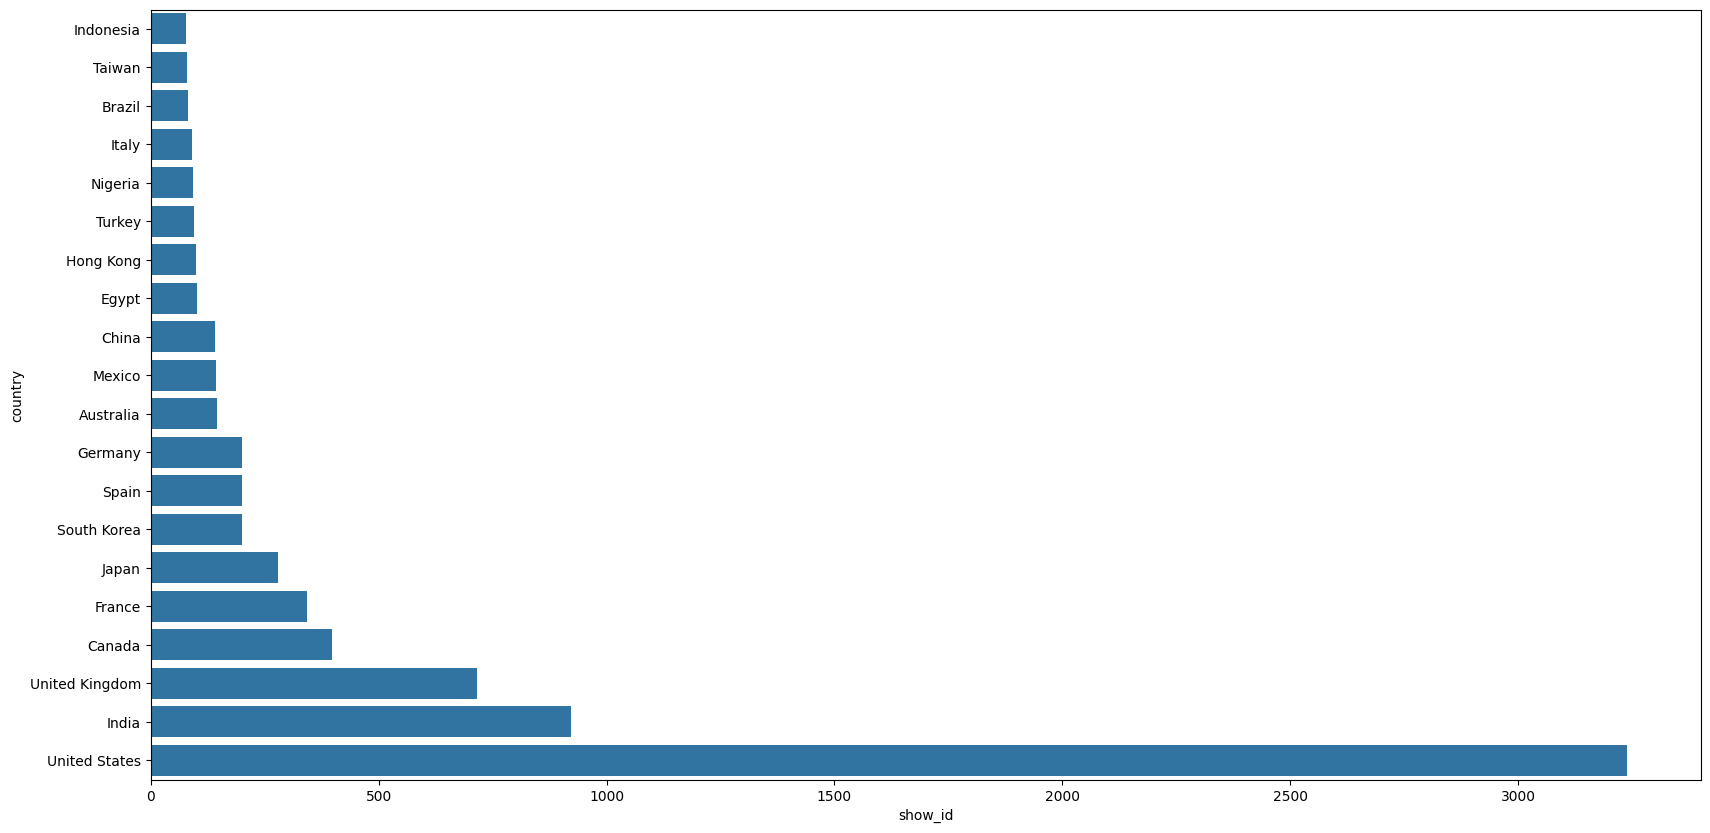

In [41]:
# 나라별 카운트 - 역시 미국이 압도적, 그 다음이 인도, 영국 - 확실히 영어권 국가들의 영상이 많다.
plt.figure(figsize=(20, 10))
sns.barplot(plot_data_country.sort_values('show_id').iloc[-20:], x="show_id", y="country", orient="h")
plt.show()

In [42]:
# country 컬럼에 대한 데이터 분석을 진행합니다.
plot_data_country = df_copy.groupby(["country", "release_year"]).count().reset_index().sort_values('show_id')
plot_data_country

,country,release_year,show_id,type,title,director,cast,date_added,rating,duration,listed_in,description,num_country,year_added,month_added
0,,1975,1,1,1,1,1,1,1,1,1,1,1,1,1
546,Lithuania,2015,1,1,1,1,1,1,1,1,1,1,1,1,1
547,Luxembourg,2011,1,1,1,0,1,1,1,1,1,1,1,1,1
548,Luxembourg,2013,1,1,1,1,1,1,1,1,1,1,1,1,1
549,Luxembourg,2014,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,United States,2016,295,295,295,239,257,294,295,295,295,295,295,294,294
1024,United States,2020,334,334,334,173,275,334,334,334,334,334,334,334,334
1023,United States,2019,380,380,380,234,325,380,380,380,380,380,380,380,380
1021,United States,2017,386,386,386,312,326,386,385,386,386,386,386,386,386


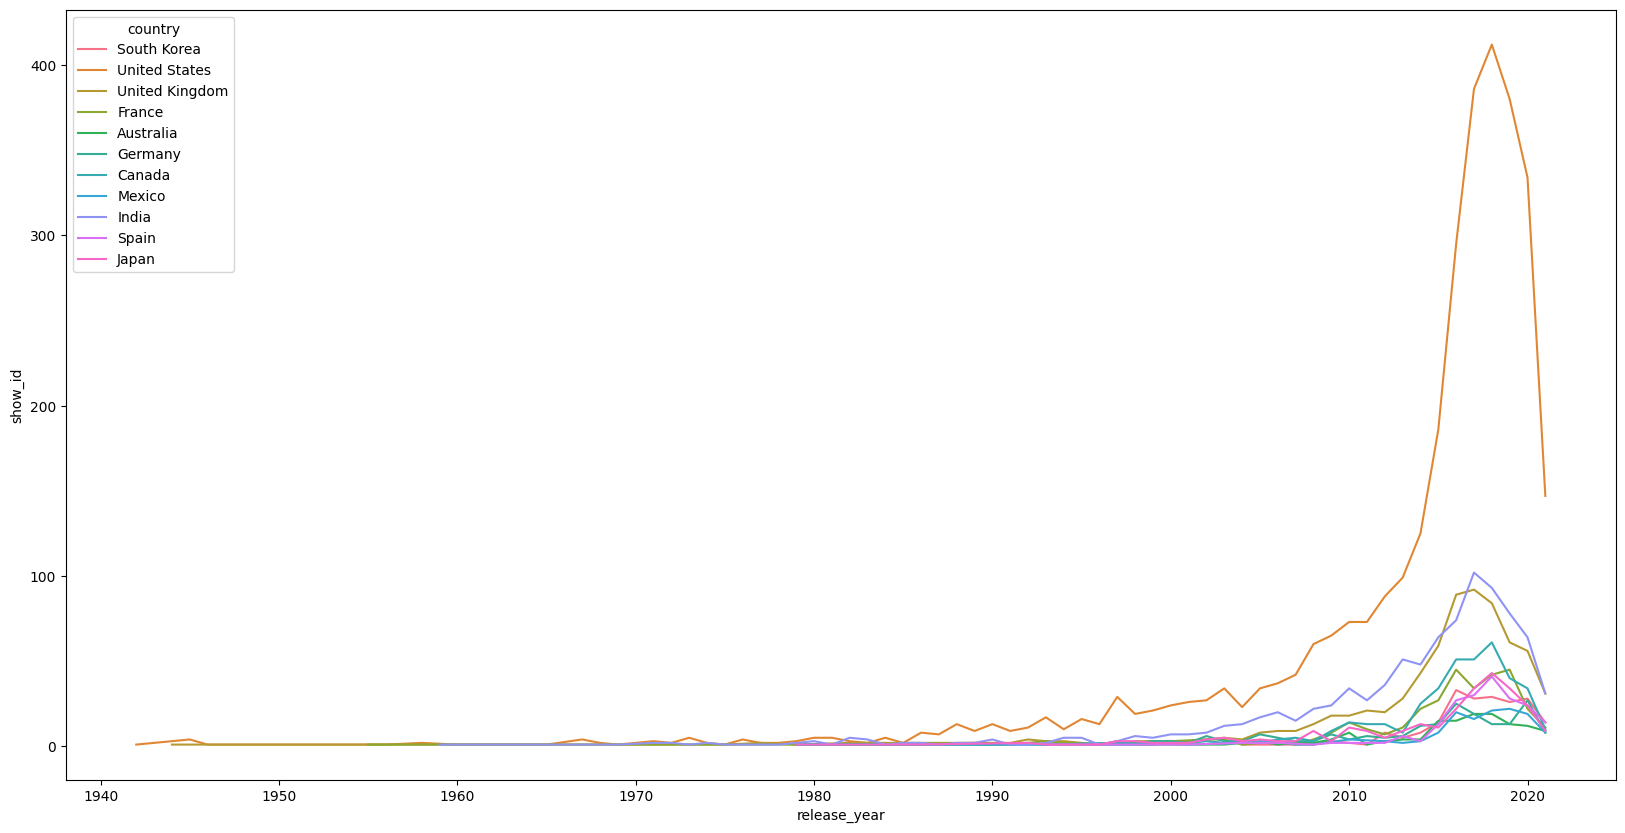

In [43]:
country_list = [
  'United States',
  'India',
  'United Kingdom',
  'Canada',
  'France',
  'Japan',
  'South Korea',
  'Spain',
  'Germany',
  'Australia',
  'Mexico'
]

plt.figure(figsize=(20, 10))
sns.lineplot(plot_data_country.sort_values('show_id').loc[plot_data_country.country.isin(country_list)], x="release_year", y="show_id", hue="country")
plt.show()

## Duration 데이터 분석
- Seasons|Season 과 min 의 분포를 확인한다
- 이 시각화 데이터를 통해 영상 제작자들이 적당한 duration 을 선택할 수 있을 것 같다.

In [44]:
netflix_df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,num_country,year_added,month_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",1,2021,September
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",1,2021,September
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,0,2021,September
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",0,2021,September
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,1,2021,September
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a...",1,2019,November
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g...",0,2019,July
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...,1,2019,November
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",1,2020,January


In [45]:
plot_duration = netflix_df['duration'].copy().values
plot_duration

array(['90 min', '2 Seasons', '1 Season', ..., '88 min', '88 min',
       '111 min'], dtype=object)

In [46]:
seasons = [float(d.split(' ')[0]) for d in plot_duration if not pd.isna(d) and d.find('min') == -1]
movies = [float(d.split(' ')[0]) for d in plot_duration if not pd.isna(d) and d.find('min') != -1]
movies

[90.0,
 91.0,
 125.0,
 104.0,
 127.0,
 91.0,
 67.0,
 94.0,
 161.0,
 61.0,
 166.0,
 147.0,
 103.0,
 97.0,
 106.0,
 111.0,
 110.0,
 105.0,
 96.0,
 124.0,
 116.0,
 98.0,
 91.0,
 23.0,
 115.0,
 122.0,
 99.0,
 99.0,
 88.0,
 100.0,
 102.0,
 93.0,
 96.0,
 95.0,
 85.0,
 97.0,
 95.0,
 83.0,
 103.0,
 113.0,
 13.0,
 182.0,
 106.0,
 48.0,
 145.0,
 145.0,
 93.0,
 106.0,
 147.0,
 87.0,
 96.0,
 95.0,
 92.0,
 91.0,
 90.0,
 97.0,
 80.0,
 117.0,
 128.0,
 90.0,
 119.0,
 110.0,
 143.0,
 119.0,
 114.0,
 94.0,
 106.0,
 99.0,
 118.0,
 115.0,
 95.0,
 115.0,
 108.0,
 63.0,
 117.0,
 121.0,
 142.0,
 113.0,
 154.0,
 95.0,
 108.0,
 120.0,
 100.0,
 82.0,
 124.0,
 114.0,
 104.0,
 94.0,
 94.0,
 93.0,
 97.0,
 109.0,
 88.0,
 101.0,
 105.0,
 102.0,
 101.0,
 103.0,
 106.0,
 118.0,
 86.0,
 121.0,
 229.0,
 76.0,
 95.0,
 98.0,
 89.0,
 120.0,
 110.0,
 83.0,
 121.0,
 105.0,
 94.0,
 156.0,
 112.0,
 95.0,
 107.0,
 114.0,
 129.0,
 86.0,
 97.0,
 125.0,
 107.0,
 127.0,
 128.0,
 92.0,
 135.0,
 124.0,
 136.0,
 165.0,
 124.0,
 136.0,

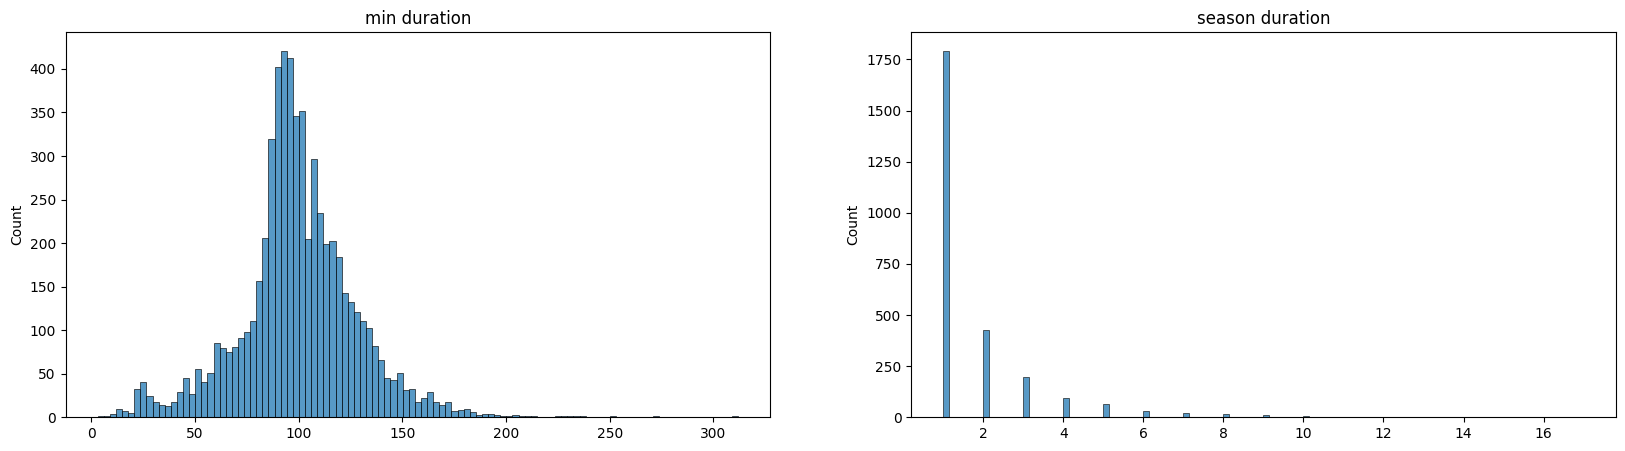

In [47]:
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
sns.histplot(movies)
plt.title('min duration')

plt.subplot(1,2,2)
sns.histplot(seasons)
plt.title('season duration')

plt.show()

## Add IMDB data to get ratings and deal with missing values
- 평점을 얻어오기 위해 IMDB movies 데이터셋을 추가해서 사용합니다. (Inner Join)
- title(original_title)로 동일한 영화를 매치해서 Netflix 데이터셋에 있는 결측값을 처리하는데 이용합니다.

In [50]:
# Load IMDB dataset (https://www.kaggle.com/datasets/mirajshah07/netflix-dataset?rvi=1)
imdb_titles = pd.read_csv(f"{DATASET_ROOT_PATH}/IMDb movies.csv")

/tmp/ipykernel_6746/4287598139.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_titles = pd.read_csv(f"{DATASET_ROOT_PATH}/IMDb movies.csv")


In [51]:
imdb_titles.head(3)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,NaN,Alexander Black,...,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,26-12-1906,"Biography, Crime, Drama",70,Australia,NaN,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,19-08-1911,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0


In [52]:
# Select necessary columns
imdb_titles = imdb_titles[["title", "original_title", "year", "country", "director", "actors", "avg_vote"]]

In [53]:
# Drop duplicated values based on title, year, and avg_vote
imdb_titles = imdb_titles.drop_duplicates(subset=["title","year","avg_vote"])
imdb_titles.shape

(85852, 7)

In [54]:
# Now, merge joint_data and netflix_df again
# to get the content that has both IMDB ratings and also available on Netflix.
# Inner Join: 교집합처럼 넷플릭스 데이터(왼쪽)와 imdb 데이터(오른쪽)에 모두 있는 영화의 정보만을 가져옵니다.
# 영화 제목을 기준으로 하는데, netflix 데이터에서는 영화 제목 column 이름이 'title', imdb에서는 'orignal_title'로 되어 있습니다.
netflix_joint_df = netflix_df.merge(imdb_titles, left_on = "title", right_on="original_title", how = "inner")

In [55]:
netflix_joint_df.info()
# 양쪽 데이터 모두에서 동일한 column명이 있다면 _x, _y를 자동으로 붙혀줍니다. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4079 entries, 0 to 4078
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   show_id         4079 non-null   object 
 1   type            4079 non-null   object 
 2   title_x         4079 non-null   object 
 3   director_x      3608 non-null   object 
 4   cast            3996 non-null   object 
 5   country_x       3961 non-null   object 
 6   date_added      4076 non-null   object 
 7   release_year    4079 non-null   int64  
 8   rating          4078 non-null   object 
 9   duration        4079 non-null   object 
 10  listed_in       4079 non-null   object 
 11  description     4079 non-null   object 
 12  num_country     4079 non-null   int64  
 13  year_added      4076 non-null   object 
 14  month_added     4076 non-null   object 
 15  title_y         4079 non-null   object 
 16  original_title  4079 non-null   object 
 17  year            4079 non-null   o

In [56]:
# Check missing values
netflix_joint_df.isnull().sum()

show_id             0
type                0
title_x             0
director_x        471
cast               83
country_x         118
date_added          3
release_year        0
rating              1
duration            0
listed_in           0
description         0
num_country         0
year_added          3
month_added         3
title_y             0
original_title      0
year                0
country_y           5
director_y          3
actors              1
avg_vote            0
dtype: int64

In [57]:
"""Netflix 데이터 결측값 처리"""
# 1) Deal with missing values using columns from 'imdb_titles' dataset 
# IMDB 데이터셋에서 불러온 columns들에 있는 값을 이용해서 기존 Netflix 데이터에 있던 결측값을 대체합니다. 
netflix_joint_df['director_x'] = netflix_joint_df.apply(lambda row: row['director_y'] if pd.isnull(row['director_x']) else row['director_x'], axis = 1)
netflix_joint_df['cast'] = netflix_joint_df.apply(lambda row: row['actors'] if pd.isnull(row['cast']) else row['cast'], axis = 1)
netflix_joint_df['country_x'] = netflix_joint_df.apply(lambda row: row['country_y'] if pd.isnull(row['country_x']) else row['country_x'], axis = 1)

In [58]:
netflix_joint_df.isnull().sum()

show_id           0
type              0
title_x           0
director_x        2
cast              0
country_x         4
date_added        3
release_year      0
rating            1
duration          0
listed_in         0
description       0
num_country       0
year_added        3
month_added       3
title_y           0
original_title    0
year              0
country_y         5
director_y        3
actors            1
avg_vote          0
dtype: int64

In [59]:
# Drop unnecessary columns 
netflix_joint_df = netflix_joint_df.drop(columns=['title_y', 'original_title', 'country_y', 'year', 'director_y', 'actors'])

In [60]:
# 2) Drop remaning NaN values
# 이후 남아있는 결측값의 수가 1~4개이기 때문에 추가로 처리를 하지 않고 Drop합니다. 
netflix_joint_df = netflix_joint_df.dropna()
netflix_joint_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4069 entries, 0 to 4078
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   show_id       4069 non-null   object 
 1   type          4069 non-null   object 
 2   title_x       4069 non-null   object 
 3   director_x    4069 non-null   object 
 4   cast          4069 non-null   object 
 5   country_x     4069 non-null   object 
 6   date_added    4069 non-null   object 
 7   release_year  4069 non-null   int64  
 8   rating        4069 non-null   object 
 9   duration      4069 non-null   object 
 10  listed_in     4069 non-null   object 
 11  description   4069 non-null   object 
 12  num_country   4069 non-null   int64  
 13  year_added    4069 non-null   object 
 14  month_added   4069 non-null   object 
 15  avg_vote      4069 non-null   float64
dtypes: float64(1), int64(2), object(13)
memory usage: 540.4+ KB


Now we have 4,069 cleaned entries

## Visualizations

In [62]:
# Top 10 rated movies or tv shows on Netflix using sunburst chart
# 가장 평점이 좋은 영화나 드라마 10개를 시각화합니다.
netflix_joint_df = netflix_joint_df.sort_values(by="avg_vote", ascending=False)
top_rated=netflix_joint_df[0:10]
fig =px.sunburst(
    top_rated,
    path=['title_x','country_x'],
    values='avg_vote',
    color='avg_vote',
    title="Top 10 rated movies on Netflix")
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [63]:
# Top 10 highest rated countries
# 각 나라별 영화의 개수를 측정하고, 이 중 가장 많은 10개의 나라만 보여줍니다.
country_count=netflix_joint_df['country_x'].value_counts().sort_values(ascending=False)
country_count=pd.DataFrame(country_count)
topcountries=country_count[0:11]
topcountries

,count
country_x,
United States,1444
India,772
United Kingdom,157
Canada,73
"United Kingdom, United States",68
Philippines,57
France,48
South Korea,47
USA,46


In [64]:
# 국가 이름도 ','로 구분이 되어 있어서, text split처리가 필요해 보입니다.
country_count

,count
country_x,
United States,1444
India,772
United Kingdom,157
Canada,73
"United Kingdom, United States",68
...,...
"Netherlands, Germany, Denmark, United Kingdom",1
"United States, Morocco",1
"India, Australia",1


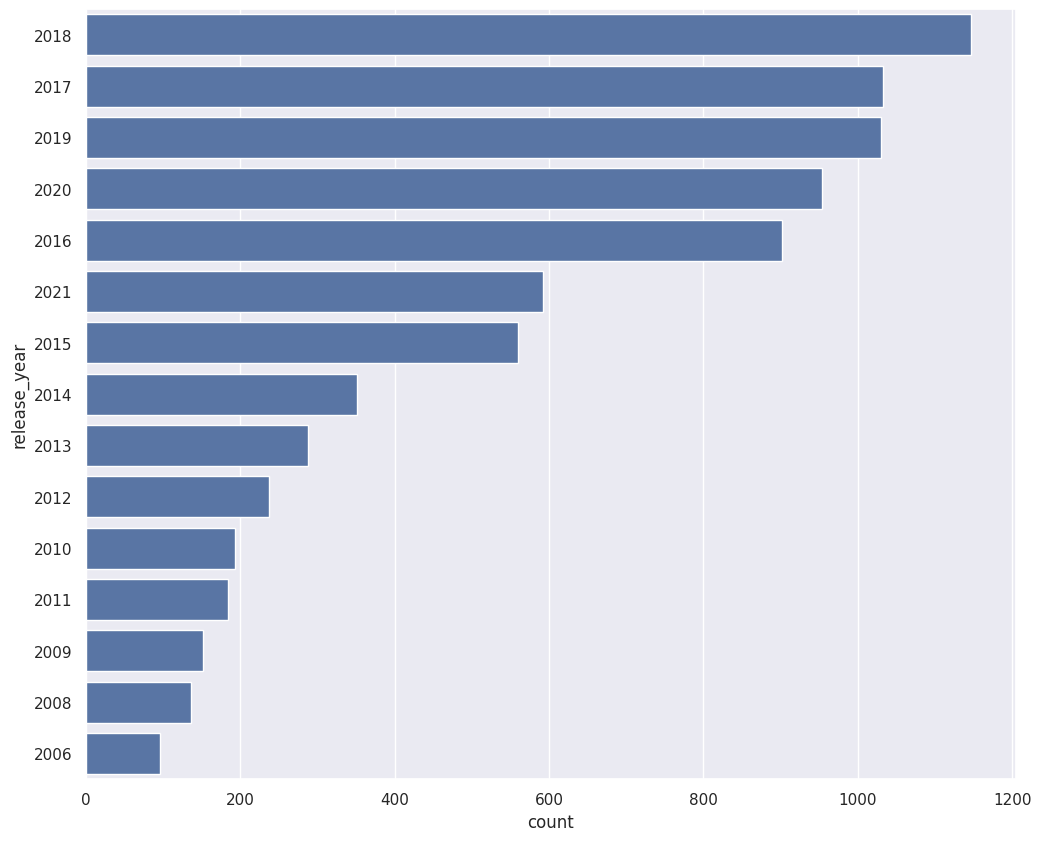

In [65]:
# How many movies were released in year-wise?
# 가장 많은 영화를 상영했던 연도를 보여줍니다. (연도 순으로 차트를 보여주는 것도 좋을 것 같음)
plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
ax = sns.countplot(y="release_year", data=netflix_df, order=netflix_df['release_year'].value_counts().index[0:15])

In [66]:
# How long does the movie play? 영화의 상영 시간 분포도를 구해봅니다.
# 1) Devide movie and tv shows (Since movie is counted by minutes and tv shows with seasons)
netflix_movies = netflix_joint_df.loc[netflix_joint_df['type'] == 'Movie'].copy()
netflix_shows = netflix_joint_df.loc[netflix_joint_df['type'] == 'TV Show'].copy()
print(netflix_movies.shape, netflix_shows.shape)

(3573, 16) (496, 16)


In [67]:
# Transform to int by removing 'min' after the numbers in 'duration'
netflix_movies['duration']= netflix_movies['duration'].str.replace(' min','')
netflix_movies['duration'] = netflix_movies['duration'].astype(str).astype(int)

<Axes: xlabel='duration', ylabel='Density'>

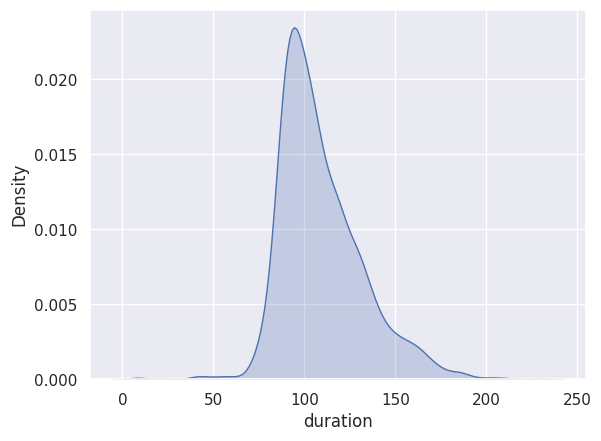

In [68]:
# Distribution of duration (play time)
sns.set(style="darkgrid")
sns.kdeplot(data=netflix_movies['duration'], fill=True)

### WordCloud
- 일부 변수들은 ','로 한 행에 여러 값이 들어가있음. 
- split 처리가 필요함.

In [69]:
from collections import Counter

genres=list(netflix_movies['listed_in']) # listed_in: genre
gen=[]

# Separate genres based on ',' 
for i in genres:
    i=list(i.split(','))
    for j in i:
        gen.append(j.replace(' ',""))
g=Counter(gen) # 워드클라우드를 만들기 위해 dataframe을 Counter함수를 사용해서 자동으로 dictionary형으로 변환 

In [70]:
gen

['ClassicMovies',
 'Dramas',
 'ClassicMovies',
 'CultMovies',
 'Dramas',
 'Action&Adventure',
 'Sci-Fi&Fantasy',
 'Action&Adventure',
 'Sci-Fi&Fantasy',
 'Thrillers',
 'Action&Adventure',
 'Sci-Fi&Fantasy',
 'Action&Adventure',
 'Sci-Fi&Fantasy',
 'InternationalMovies',
 'RomanticMovies',
 'Dramas',
 'InternationalMovies',
 'Dramas',
 'IndependentMovies',
 'InternationalMovies',
 'Dramas',
 'InternationalMovies',
 'Thrillers',
 'ClassicMovies',
 'Comedies',
 'InternationalMovies',
 'Dramas',
 'InternationalMovies',
 'Dramas',
 'IndependentMovies',
 'InternationalMovies',
 'Dramas',
 'InternationalMovies',
 'Dramas',
 'IndependentMovies',
 'InternationalMovies',
 'Dramas',
 'InternationalMovies',
 'Dramas',
 'Dramas',
 'IndependentMovies',
 'InternationalMovies',
 'Comedies',
 'InternationalMovies',
 'Music&Musicals',
 'Action&Adventure',
 'IndependentMovies',
 'HorrorMovies',
 'InternationalMovies',
 'Thrillers',
 'Dramas',
 'Thrillers',
 'Dramas',
 'IndependentMovies',
 'International

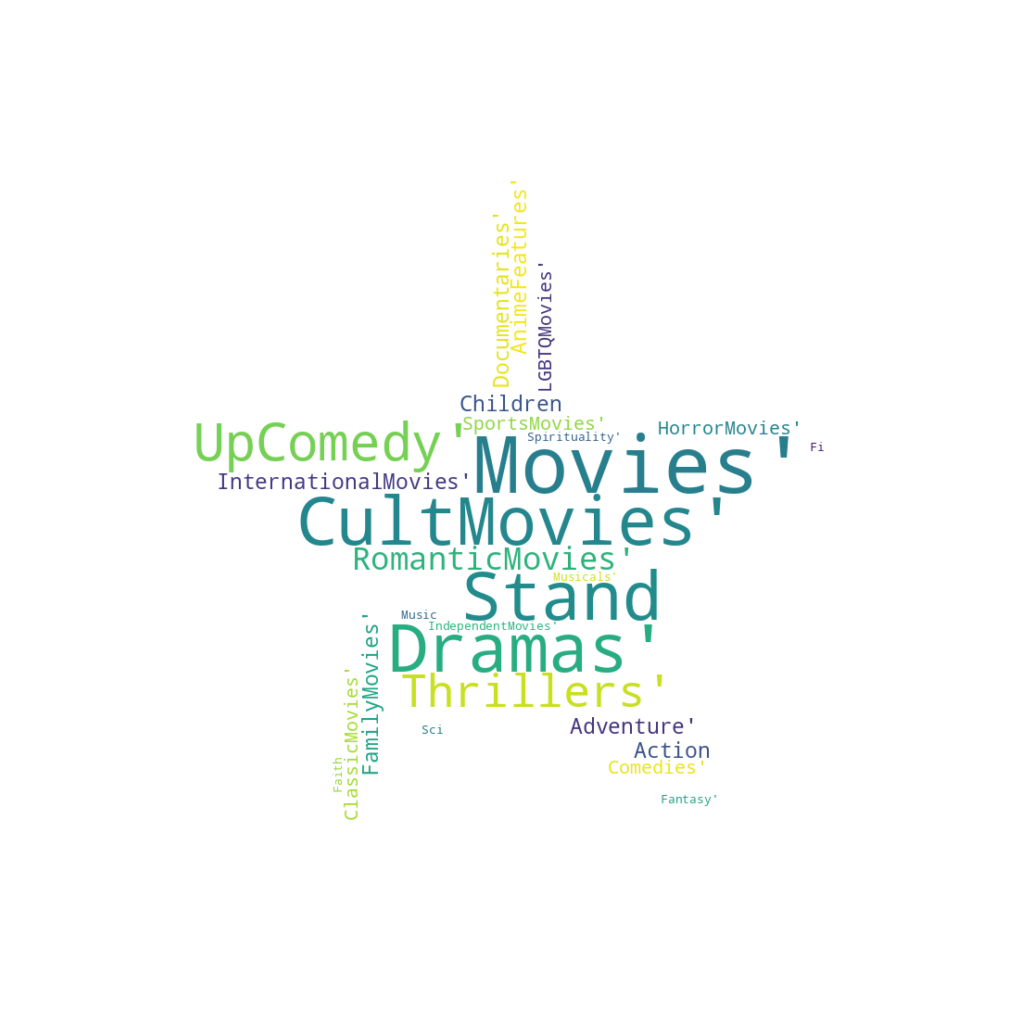

In [72]:
# Create wordcloud for genres to see what kinds of genres are dominated
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

text = list(set(gen))
plt.rcParams['figure.figsize'] = (13, 13)

# assigning shape to the word cloud
mask = np.array(Image.open('./mask_image/star.png'))
wordcloud = WordCloud(max_words=1000000,background_color="white",mask=mask).generate(str(text))

plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

/tmp/ipykernel_6746/3580691374.py:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Text(0.5, 1.0, 'Genres')

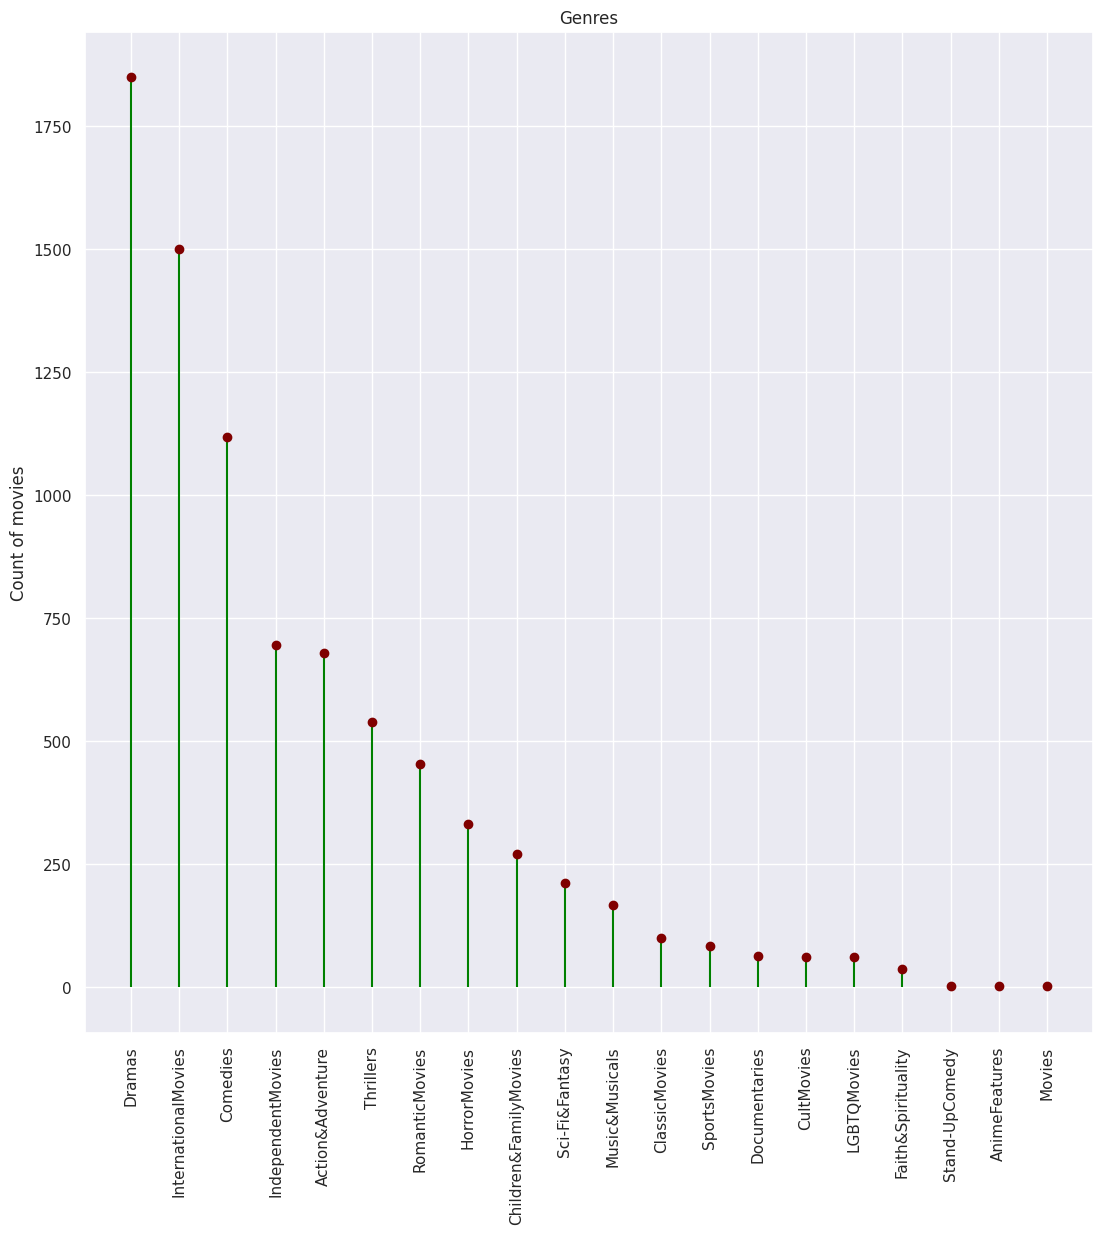

<Figure size 1000x1000 with 0 Axes>

In [73]:
# Lolipop plots to see the counts of movies based on genres
g={k: v for k, v in sorted(g.items(), key=lambda item: item[1], reverse= True)}

fig, ax = plt.subplots()

fig = plt.figure(figsize = (10, 10))
x=list(g.keys())
y=list(g.values())
ax.vlines(x, ymin=0, ymax=y, color='green')
ax.plot(x,y, "o", color='maroon')
ax.set_xticklabels(x, rotation = 90)
ax.set_ylabel("Count of movies")
# set a title
ax.set_title("Genres")

## Content-Based Recommendation System
- Content-Based Filtering: 사용자가 소비한 아이템에 대해 아이템의 내용(content)이 비슷하거나 특별한 관계가 있는 다른 아이템을 추천하는 방법
- using TF-IDF(Term Frequency-Inverse Document Frequency) scores and
- consine similarity

1) Use 'description' to recommend similar movies or TV shows
2) Strings handling (stopwords, empty string, etc.)
3) Create TF-IDF matrix 
4) Use consine similarity score to recommend

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#removing stopwords
tfidf = TfidfVectorizer(stop_words='english')
countvector = CountVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(netflix_joint_df['description'])
count_matrix = countvector.fit_transform(netflix_joint_df['description'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4069, 10226)

In [89]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim_count = cosine_similarity(count_matrix, count_matrix)
print(cosine_sim)
print("\n")
print(cosine_sim_count)
cosine_sim.shape

[[1.         0.         0.         ... 0.         0.         0.1062854 ]
 [0.         1.         0.         ... 0.02557778 0.0262569  0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.02557778 0.         ... 1.         0.02805033 0.        ]
 [0.         0.0262569  0.         ... 0.02805033 1.         0.        ]
 [0.1062854  0.         0.         ... 0.         0.         1.        ]]


[[1.         0.         0.         ... 0.         0.         0.14322297]
 [0.         1.         0.         ... 0.07161149 0.06900656 0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.07161149 0.         ... 1.         0.07412493 0.        ]
 [0.         0.06900656 0.         ... 0.07412493 1.         0.        ]
 [0.14322297 0.         0.         ... 0.         0.         1.        ]]


(4069, 4069)

TF-IDF는 Term의 TF,와 DF의 역수인 IDF를 이용해 Text의 특징을 추출하는 방법이고

CountVector 부분은 Term의 수를 계산해서 Text의 특징을 추출하는 방법

In [ ]:
def vector(description, director, cast ,listed_in):
    '''
    A function that vectors a show

    Args : description : show의 설명
           director : show의 감독
           cast : show의 배우
           insted_in : 장르
    output : description_cate * 0.4 + listed_in_cate * 0.3 + director_cate * 0.2 + cast_cate * 0.1
    '''
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    # TfidfVectorizer #
    vectorizer = TfidfVectorizer(stop_words='english')

    # description #
    description_vector = vectorizer.fit_transform(description)
    description_cate = cosine_similarity(description_vector)
    
    # director #
    director_vector = vectorizer.fit_transform(director)
    director_cate = cosine_similarity(director_vector)

    # cast
    cast_vector = vectorizer.fit_transform(cast)
    cast_cate = cosine_similarity(cast_vector)

    # cast
    listed_in_vector = vectorizer.fit_transform(listed_in)
    listed_in_cate = cosine_similarity(listed_in_vector)

    return description_cate * 0.4 + listed_in_cate * 0.3 + director_cate * 0.2 + cast_cate * 0.1

In [94]:
indices = pd.Series(netflix_joint_df.index, index=netflix_joint_df['title_x']).drop_duplicates()

def get_recommendations(title_x, cosine_sim=cosine_sim):
    idx = indices[title_x]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return netflix_joint_df[['title_x', 'director_x', 'listed_in', 'avg_vote']].iloc[movie_indices].sort_values('avg_vote', ascending = False)

title_x
Innocent                                         1695
Schindler's List                                 3547
Pulp Fiction                                     3447
The Lord of the Rings: The Return of the King    3857
Inception                                         140
                                                 ... 
Himmatwala                                       1818
Ride or Die                                       457
Aerials                                          1043
Welcome to New York                              4034
Pink                                             2381
Length: 4069, dtype: int64


In [93]:
get_recommendations("Pulp Fiction")

3447
1 -> [(0, 0.031201786344071294), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0), (10, 0.0), (11, 0.0), (12, 0.0), (13, 0.0), (14, 0.0), (15, 0.0), (16, 0.0), (17, 0.0), (18, 0.0), (19, 0.0), (20, 0.0), (21, 0.0), (22, 0.0), (23, 0.0), (24, 0.0), (25, 0.0), (26, 0.0), (27, 0.0), (28, 0.0), (29, 0.0), (30, 0.0), (31, 0.0), (32, 0.0), (33, 0.0), (34, 0.0), (35, 0.0), (36, 0.0), (37, 0.0), (38, 0.0), (39, 0.0), (40, 0.0), (41, 0.0), (42, 0.0), (43, 0.0), (44, 0.0), (45, 0.0), (46, 0.0), (47, 0.0), (48, 0.0), (49, 0.0), (50, 0.0), (51, 0.0), (52, 0.0), (53, 0.0), (54, 0.0), (55, 0.026598862955353773), (56, 0.0), (57, 0.0), (58, 0.0), (59, 0.0), (60, 0.0), (61, 0.0), (62, 0.0), (63, 0.08408213441462169), (64, 0.0), (65, 0.0), (66, 0.03492195856086651), (67, 0.0), (68, 0.0), (69, 0.0), (70, 0.0), (71, 0.0), (72, 0.0), (73, 0.0), (74, 0.0), (75, 0.0), (76, 0.0), (77, 0.04530694857129896), (78, 0.0), (79, 0.0), (80, 0.0), (81, 0.0), (82, 0.0), (83,

,title_x,director_x,listed_in,avg_vote
598,Rango,Gore Verbinski,"Children & Family Movies, Comedies",7.2
3003,Hükümet Kadin,Sermiyan Midyat,"Comedies, International Movies",6.5
3130,Jericho,Merlin Miller,"Classic & Cult TV, TV Action & Adventure, TV D...",6.1
3129,Jericho,Thornton Freeland,"Classic & Cult TV, TV Action & Adventure, TV D...",6.1
721,In a Valley of Violence,Ti West,Action & Adventure,6.0
2409,Rainbow Time,Linas Phillips,"Comedies, Dramas, Independent Movies",5.9
2157,Fun Mom Dinner,Alethea Jones,"Comedies, International Movies",5.2
2189,The Killer,Marcelo Galvão,"Action & Adventure, International Movies",4.6
1224,Justice,Richard Gabai,Movies,4.5
1225,Justice,Richard Gabai,Movies,4.0
